# Convolutional neural network

![CNN representation from https://stanford.edu/~shervine/teaching/cs-230/](https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-en.jpeg?3b7fccd728e29dc619e1bd8022bf71cf)

For our example, we will use the [chest X-ray data-set](https://drive.google.com/file/d/1Y9iTkRrfh_2UfoG9o8CRjZc_3rj73nap/view)
from [Kermany et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418301545?via%3Dihub)

| normal | pneumonia |
| --- | --- |
| <img alt='a sample normal chest x-ray from Kermany et al. 2018' src='images/NORMAL-1003233-0001.jpeg' width="400"> | <img alt='a pneumonia normal chest x-ray from Kermany et al. 2018' src='images/BACTERIA-1008087-0001.jpeg' width="400"> |
 


If you need a refresher, you can use the excellent [CNN cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

from torchvision.transforms import v2
import torchvision

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")




Using cuda device


## data pre-processing 

The dataset contains 
 * 1584 normal x-rays (1349 in train, 234 in validation) 
 * 4274 pneumonia x-rays (3883 in train, 390 in validation)

The original data-set is around 1.2GB in size 

In [2]:
from torchvision.io import read_image

imgN = read_image( "images/NORMAL-1003233-0001.jpeg" )
imgP = read_image( "images/BACTERIA-1008087-0001.jpeg" )

imgN.shape , imgP.shape

(torch.Size([1, 2476, 2572]), torch.Size([1, 1032, 1152]))

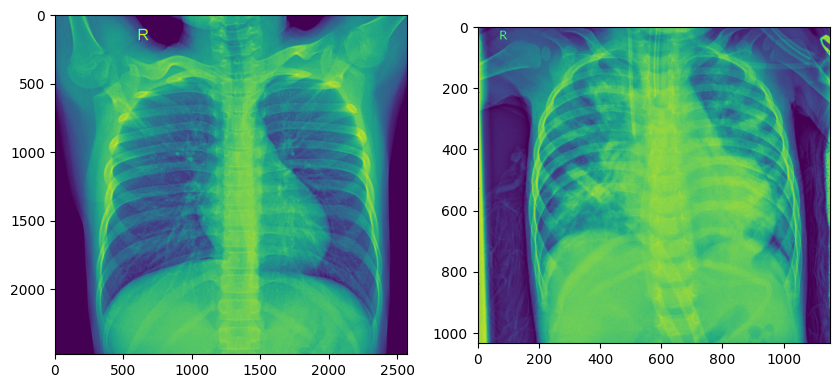

In [3]:
fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(imgN.numpy()[0])
ax[1].imshow(imgP.numpy()[0])

As they are, each image has its own size, and width to height ratio, so we will need to resize them to a common size first.

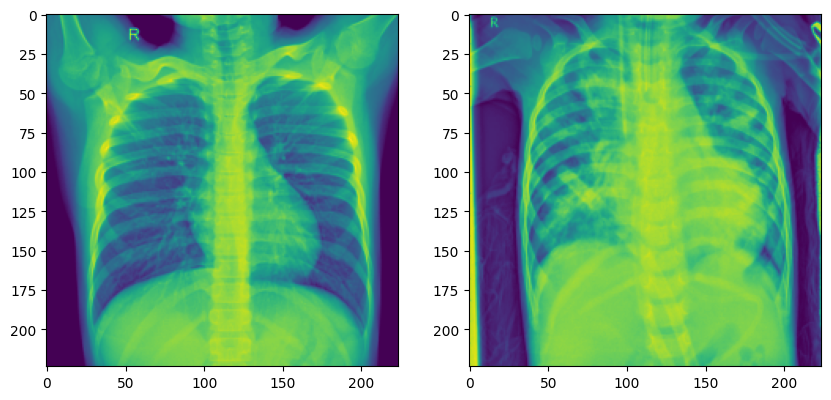

In [4]:
### We use the transformers from torchvision.v2
R = v2.Resize( size = (224,224) , antialias = True ) 
fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(R(imgN).numpy()[0])
ax[1].imshow(R(imgP).numpy()[0])

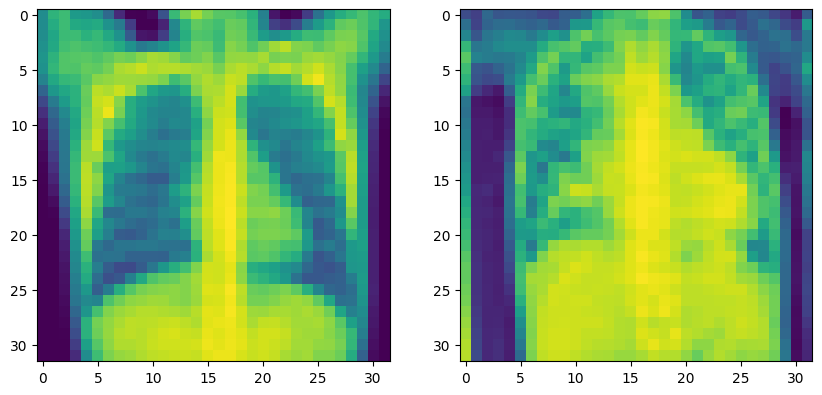

In [5]:
R = v2.Resize( size = (32,32) , antialias = True ) 
fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(R(imgN).numpy()[0])
ax[1].imshow(R(imgP).numpy()[0])

How much should we resize? 

Should we do other operations?

In image-based applications, it is common to augment a data-set by randomly cropping, rotating, and flipping the  images or shifting their colors or contrast for example.

This is done to make the model resilient to such changes (a picture of a cat should still be classified as a cat, even if the cat is upside-down and in a dark room).


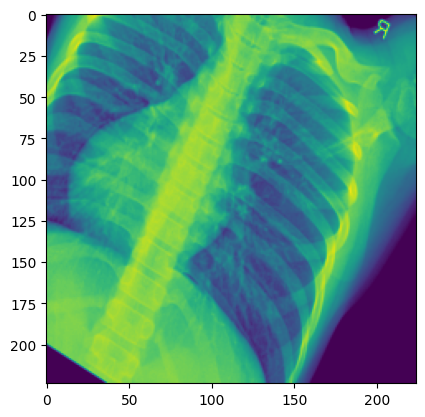

In [6]:
### The classical stuff for classification : flip, crop, resize rotate
## see : https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py
## for more details

from torchvision.transforms import v2
transforms = v2.Compose([
    v2.RandomRotation(45),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485], std=[0.229]),
])
out = transforms(imgN)

plt.imshow( out.numpy()[0] )

In our case, all our images are fairly well framed x-ray shots and we expect that new images would be similarly well-behaved, so we are only going to apply a resizing and a transformation of the pixel values to floats.

---

For the resize, we will go with a 224x224 size, which is a drastic diminution but still enough to get a fairly good classifier (it will become clear why exactly these values in the next notebook).


The image dataset in organized in several folder: one per target category (here NORMAL and PNEUMONIA).

This is a fairly typical way to organize things, so torchvision already has utilities to load this data

In [7]:
##
## Here in order to keep the github repo somewhat light we have not included the full resolution images in it
##  but we still keep this time code to in order to showcase how it would behave:
##
# %%time
# train = torchvision.datasets.ImageFolder("data/chest_xray/train/" , 
#                                          loader = read_image)

# sizes = []
# for x,y in train:
#     sizes.extend(x.shape[1:])
# print('minimum size:', min(sizes))
# print('maximum size:', max(sizes))

Just reading the dataset took ~33.6 s

It becomes even worse when you add the resize transformation:

In [8]:
# %%time
# R = v2.Resize( size = (224,224) , antialias = True ) 
# train = torchvision.datasets.ImageFolder("data/chest_xray/train/" , 
#                                          loader = read_image,
#                                         transform = R)
# sizes = []
# for x,y in train:
#     sizes.extend(x.shape[1:])
# print('minimum size:', min(sizes))
# print('maximum size:', max(sizes))

You have to think that this would be done at each epoch, so it is not ideal for our performance.

When the dataset is not too large, you could keep all the images in RAM as Tensors and forego this.

Here, because we do not want to do any other transform that a simple resize, we have kept the resized images and use this as dataset (this serves the additional purpose of having the data in the github repo while keeping it light).

In [9]:
# %%time
##
## code to read the full res-images, transform them and write the result to disk
# import os
# from PIL import Image
# R = v2.Resize( size = (224,224) , antialias = True ) 
# train = torchvision.datasets.ImageFolder("data/chest_xray/train/" , 
#                                          loader = read_image,
#                                         transform = R)

# baseFolder = 'data/chest_xray_224/train/' 

# targets = ["NORMAL",'PNEUMONIA']
# for t in targets:
#     os.makedirs( baseFolder + t )
# for i , XY in enumerate( train ) :
#     x,y = XY
    
#     folder = baseFolder + targets[y]
#     im = Image.fromarray(x.numpy()[0])
#     im.save( folder + '/' + targets[y] + '_' + str(i) + ".jpeg" )


In [10]:
# %%time
# import os
# from PIL import Image
# R = v2.Resize( size = (224,224) , antialias = True ) 
# train = torchvision.datasets.ImageFolder("data/chest_xray/test/" , 
#                                          loader = read_image,
#                                         transform = R)

# baseFolder = 'data/chest_xray_224/test/' 

# targets = ["NORMAL",'PNEUMONIA']
# for t in targets:
#     os.makedirs( baseFolder + t )
# for i , XY in enumerate( train ) :
#     x,y = XY
    
#     folder = baseFolder + targets[y]
#     im = Image.fromarray(x.numpy()[0])
#     im.save( folder + '/' + targets[y] + '_' + str(i) + ".jpeg" )
    

In [11]:
%%time
tmp = torchvision.datasets.ImageFolder("data/chest_xray_224/train/" , 
                                         loader = read_image)

sizes = []
for x,y in tmp:
    sizes.extend(x.shape[1:])
print('minimum size:', min(sizes))
print('maximum size:', max(sizes))

minimum size: 224
maximum size: 224
CPU times: user 778 ms, sys: 217 ms, total: 995 ms
Wall time: 1.08 s


much faster 

And so, creating our datasets looks like:

In [12]:
train_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/train', 
                                         loader = read_image,
                                         transform = v2.ToDtype(torch.float32),
                                         target_transform = lambda x : torch.Tensor([x])  )
valid_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/test', 
                                         loader = read_image,
                                         transform = v2.ToDtype(torch.float32),
                                         target_transform = lambda x : torch.Tensor([x])   )
    
    
batch_size = 64
train_dataloader = DataLoader( dataset= train_dataset , shuffle=True , batch_size = batch_size )
valid_dataloader = DataLoader( dataset= valid_dataset , shuffle=True , batch_size = batch_size )


**Question:** why do we use `shuffle = True` here ?

## model

first the classical definitions:

In [13]:
def train(dataloader, model, loss_fn, optimizer ,  echo = True , echo_batch = False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X,y) in enumerate(dataloader): # for each batch
        X = X.to(device) # send the data to the GPU or whatever device you use for training
        y = y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction        
        
        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch) * dataloader.batch_size +  len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    if echo:
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()


In [14]:
def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches
            
    valid_loss /= num_batches

    if echo:
        print(f"Valid Error: {valid_loss:>8f}")
    ## return the average loss / batch
    return valid_loss


---

Our model will chain a convolutional element with a more classical classifier.



In [12]:

class CNN(nn.Module):
    def __init__(self, input_size = 224,
                       channel_numbers=1 , 
                       kernel_size= 16, 
                       stride = 4):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = channel_numbers , 
                      out_channels = 2, 
                      kernel_size = kernel_size, 
                      stride= stride ),
            nn.ReLU(True), # inplace ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size=5, stride=1),
            nn.ReLU(True), 
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.flatten = nn.Flatten()
        
        ###
        flatten_output_dim = ... ## FIND THIS VALUE
        ###
        
        self.classifier = nn.Sequential(
            nn.Linear(flatten_output_dim, 16),
            nn.Linear(16, 8), 
            nn.Linear(8, 1),
            nn.Sigmoid())

    def forward(self, x):

        out = self.conv(x)

        out = self.flatten(out)

        out = self.classifier(out)

        return out


model = CNN(input_size = 224,
            channel_numbers=1 , 
            kernel_size= 16, 
            stride = 4).to(device)
model

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got ellipsis"

**Exercise:** Find the value `flatten_output_dim` : the dimension of the elements getting out of the convolutional layer (after flattening).

If you have the correct size, the following cell will run without issue.

> hint : 
> - 2D convolutional layer:
>     - [concept](https://ml-cheatsheet.readthedocs.io/en/latest/layers.html#convolution)
>     - [pytorch doc](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
>
> - 2D max pool layer
>     - [concept](https://ml-cheatsheet.readthedocs.io/en/latest/layers.html#pooling)
>     - [pytorch doc](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d)


In [16]:
x,y = train_dataset[0]
print(pms.summary(model, x.reshape(1,1,224,224).to(device) , show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1     [1, 1, 224, 224]             514             514
            ReLU-2       [1, 2, 53, 53]               0               0
       MaxPool2d-3       [1, 2, 53, 53]               0               0
          Conv2d-4       [1, 2, 26, 26]             204             204
            ReLU-5       [1, 4, 22, 22]               0               0
       MaxPool2d-6       [1, 4, 22, 22]               0               0
         Flatten-7       [1, 4, 11, 11]               0               0
          Linear-8             [1, 484]           7,760           7,760
          Linear-9              [1, 16]             136             136
         Linear-10               [1, 8]               9               9
        Sigmoid-11               [1, 1]               0               0
Total params: 8,623
Trainable params: 8,623
Non-trainable param

In [15]:
# %load solutions/CNN_flatten_output_dim.py
input_size = 224
kernel_size = 16
stride = 4
O1 = int( 1 + ((input_size - (kernel_size-1)-1)/stride) ) 
O2 = int(  O1 / 2  ) 
O3 =  1 + ((O2 - (5-1)-1)/1) 
O4 = int(  O3 / 2  ) 
flatten_output_dim = O4**2*4

print( O1,O2,O3,O4 , sep = ' > ')
print( '-> flatten, with 4 channels' ,  flatten_output_dim )



class CNN(nn.Module):
    def __init__(self, input_size = 224,
                       channel_numbers=1 , 
                       kernel_size= 16, 
                       stride = 4):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = channel_numbers , 
                      out_channels = 2, 
                      kernel_size = kernel_size, 
                      stride= stride ),
            nn.ReLU(True), # inplace ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size=5, stride=1),
            nn.ReLU(True), 
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.flatten = nn.Flatten()
        
        ###
        flatten_output_dim = 484
        ###
        
        self.classifier = nn.Sequential(
            nn.Linear(flatten_output_dim, 16),
            nn.Linear(16, 8), 
            nn.Linear(8, 1),
            nn.Sigmoid())

    def forward(self, x):

        out = self.conv(x)

        out = self.flatten(out)

        out = self.classifier(out)

        return out


model = CNN(input_size = 224,
            channel_numbers=1 , 
            kernel_size= 16, 
            stride = 4).to(device)
model


53 > 26 > 22.0 > 11
-> flatten, with 4 channels 484


CNN(
  (conv): Sequential(
    (0): Conv2d(1, 2, kernel_size=(16, 16), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=484, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Let's get a batch to check that we can compute our loss

In [17]:
for batch, (X,y) in enumerate(train_dataloader): # for each batch
    print(batch , X.shape, y.shape)
    break

0 torch.Size([64, 1, 224, 224]) torch.Size([64, 1])


In [18]:
loss = nn.BCELoss()

with torch.no_grad():
    pred = model(X.to(device))
    print(pred.shape)
    print( 'avg loss:', loss( pred , y.to(device) ) )

torch.Size([64, 1])
avg loss: tensor(0.8443, device='cuda:0')


In [22]:
## we also define this to easily get accuracy 
def get_model_accuracy(model, dataloader):
    Ys = np.array([] , dtype = 'float32' )
    Ps = np.array([], dtype = 'float32' )
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            Ys = np.concatenate([Ys, y.squeeze().cpu().numpy()])
            Ps = np.concatenate([Ps, (pred>0.5).squeeze().cpu().numpy()])

    return np.mean( Ys == Ps )

In [20]:
## preamble -> define the model, the loss function, and the optimizer
model = CNN(input_size = 224,
            channel_numbers=1 , 
            kernel_size= 16, 
            stride = 4).to(device)


loss = nn.BCELoss()

#optimizer = torch.optim.SGD(model.parameters(), lr = 5*10**-5 , momentum=0.9) 
optimizer = torch.optim.Adam(model.parameters(), lr = 10**-4 ) 


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here. 
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)


In [23]:
## naive performance
print( "train accuracy:", get_model_accuracy(model, train_dataloader) )
print( "valid accuracy:", get_model_accuracy(model, valid_dataloader) )

train accuracy: 0.25783639143730885
valid accuracy: 0.375


In [24]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader, 
                           model, 
                           loss, 
                           optimizer, 
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader, 
                           model, 
                           loss , 
                           echo = True) )


Train loss: 1.704461  [   64/ 5232]
Train loss: 1.284382  [  128/ 5232]
Train loss: 1.120438  [  192/ 5232]
Train loss: 0.947837  [  256/ 5232]
Train loss: 0.803310  [  320/ 5232]
Train loss: 0.761810  [  384/ 5232]
Train loss: 0.664695  [  448/ 5232]
Train loss: 0.627750  [  512/ 5232]
Train loss: 0.634485  [  576/ 5232]
Train loss: 0.600269  [  640/ 5232]
Train loss: 0.682530  [  704/ 5232]
Train loss: 0.592464  [  768/ 5232]
Train loss: 0.599588  [  832/ 5232]
Train loss: 0.595129  [  896/ 5232]
Train loss: 0.685240  [  960/ 5232]
Train loss: 0.630121  [ 1024/ 5232]
Train loss: 0.639029  [ 1088/ 5232]
Train loss: 0.705877  [ 1152/ 5232]
Train loss: 0.606912  [ 1216/ 5232]
Train loss: 0.599197  [ 1280/ 5232]
Train loss: 0.593147  [ 1344/ 5232]
Train loss: 0.650984  [ 1408/ 5232]
Train loss: 0.620674  [ 1472/ 5232]
Train loss: 0.611307  [ 1536/ 5232]
Train loss: 0.684281  [ 1600/ 5232]
Train loss: 0.638229  [ 1664/ 5232]
Train loss: 0.626292  [ 1728/ 5232]
Train loss: 0.612112  [ 1792

In [25]:
%%time

epoch = 10



for t in range(epoch):
    echo = t%1==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader, 
                               model, 
                               loss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader, 
                               model, 
                               loss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2
Train loss: 0.331113
Valid Error: 0.398328
Epoch 3
Train loss: 0.173026
Valid Error: 0.345984
Epoch 4
Train loss: 0.136010
Valid Error: 0.476250
EarlyStopping counter: 1 out of 25
Epoch 5
Train loss: 0.093973
Valid Error: 0.404771
EarlyStopping counter: 2 out of 25
Epoch 6
Train loss: 0.200177
Valid Error: 0.539734
EarlyStopping counter: 3 out of 25
Epoch 7
Train loss: 0.181110
Valid Error: 0.524177
EarlyStopping counter: 4 out of 25
Epoch 8
Train loss: 0.032142
Valid Error: 0.414728
EarlyStopping counter: 5 out of 25
Epoch 9
Train loss: 0.087885
Valid Error: 0.549698
EarlyStopping counter: 6 out of 25
Epoch 10
Train loss: 0.209143
Valid Error: 0.494858
EarlyStopping counter: 7 out of 25
Epoch 11
Train loss: 0.058954
Valid Error: 0.358592
EarlyStopping counter: 8 out of 25
CPU times: user 33min 47s, sys: 5.35 s, total: 33min 53s
Wall time: 1min 9s


<timed exec>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

Text(0, 0.5, 'BCE loss')

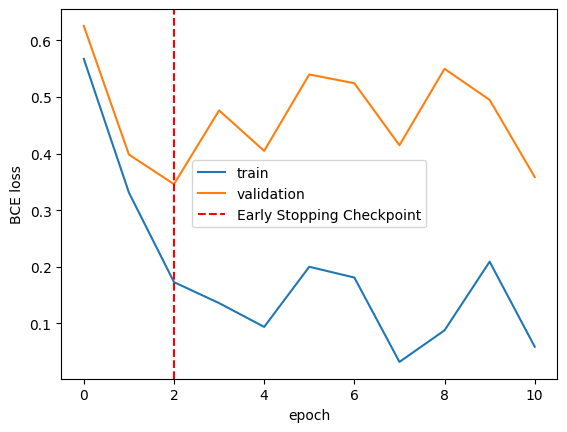

In [26]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('BCE loss')

In [27]:
print( "train accuracy:", get_model_accuracy(model, train_dataloader) )
print( "valid accuracy:", get_model_accuracy(model, valid_dataloader) )


train accuracy: 0.9088302752293578
valid accuracy: 0.8541666666666666


This is not stellar, but it is already fairly nice!

## Exercise: 

We have used 224x224 images there. 

But maybe for this fairly simple task one could use much smaller images and still get an OK results?

We have created a version of this dataset with 64x64 images, in `data/chest_xray_64/train`.

create adapted dataloaders and adapt the model achitecture.

For example, change the convolutional layer stride and kernel (now there is less pixels, so each pixel counts, so a smaller stride could me more appropriate).

> In our experience, for a model trained for approximately 1 or 2 minutes, you should get performances slightly lower that with the 224x224 images but still respectable 

> Note: models I tried have much less parameters and run faster than the one with bigger image, so each epoch was faster and so I let them run for more epoch. I also needed to decrease the learning rate.

In [ ]:
## code to create the 64x64 dataset
##
# %%time
# import os
# from PIL import Image
# S = 64
# R = v2.Resize( size = (S,S) , antialias = True ) 

# for T in ['train','test']:
#     dataset = torchvision.datasets.ImageFolder("data/chest_xray/"+T+"/" , 
#                                              loader = read_image,
#                                             transform = R)

#     baseFolder = 'data/chest_xray_'+str(S)+'/'+T+'/' 

#     targets = ["NORMAL",'PNEUMONIA']
#     for t in targets:
#         os.makedirs( baseFolder + t ,exist_ok=True)
#     for i , XY in enumerate( dataset ) :
#         x,y = XY

#         folder = baseFolder + targets[y]
#         im = Image.fromarray(x.numpy()[0])
#         im.save( folder + '/' + targets[y] + '_' + str(i) + ".jpeg" )


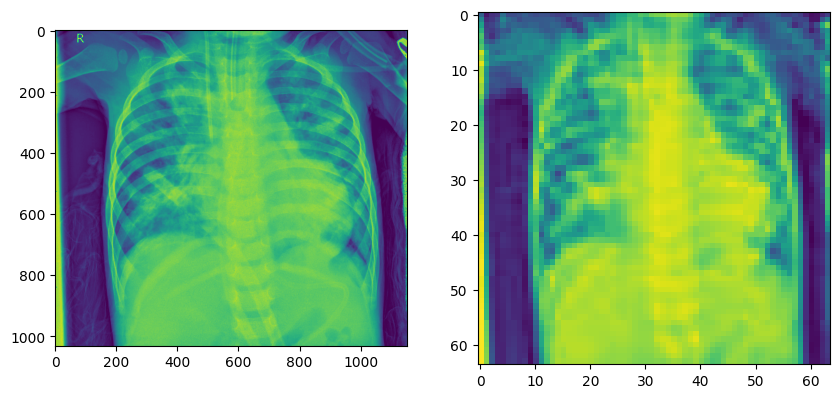

In [28]:
from torchvision.io import read_image


imgFull    = read_image( "images/BACTERIA-1008087-0001.jpeg" )
imgReduced = read_image( "data/chest_xray_64/train/PNEUMONIA/PNEUMONIA_1349.jpeg" )

fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(imgFull.numpy()[0])
ax[1].imshow(imgReduced.numpy()[0])

Creating the dataloader

In [51]:
# %load -r 1-14 solutions/CNN_exercise_64.py

Defining the model with a parametric way of getting the `flatten_output_dim`

In [50]:
# %load -r 15-64 solutions/CNN_exercise_64.py

testing the model

In [49]:
# %load -r 65-79 solutions/CNN_exercise_64.py

training preamble

In [48]:
# %load -r 80-106 solutions/CNN_exercise_64.py

Single round

In [47]:
# %load -r 107-117 solutions/CNN_exercise_64.py

training many epochs

In [46]:
# %load -r 118-147 solutions/CNN_exercise_64.py

model evaluation

In [45]:
# %load -r 148- solutions/CNN_exercise_64.py

# uncorrected extra exercise: CNN for protein subcellular location

Go back to the protein subcellular location from notebook 02 and implement a CNN to classify this dataset.

We do not present its correction, but this should yield a small increase in performance on this difficult dataset.